<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/covid-19-active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Project: Estimating current infections (including undiagnosed) from multiple sources](https://docs.google.com/document/d/1uWIsTnw2hFSlPUDSDMiw2M54M9S38oC8YIRYt20HBA0/edit#)



In [0]:
import google
#Authenticate (sometimes needs user interaction, so don't hide this cell)
google.colab.auth.authenticate_user()

# Setup

## General

In [0]:
!pip install -q pendulum pycountry

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 10.0MB 23.3MB/s 
     |████████████████████████████████| 491kB 50.9MB/s 


In [0]:
%load_ext google.colab.data_table

In [0]:
import pandas as pd
import pendulum
import gspread
import numpy as np
import math
import pycountry
import datetime

from io import StringIO
from types import SimpleNamespace

from oauth2client.client import GoogleCredentials

## Ergo

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@dashboardv3
!pip install --quiet pendulum seaborn
import ergo

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 2.7MB 8.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 522kB 8.7MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Epimodel

In [0]:
!git clone -q https://github.com/epidemics/epimodel
%cd epimodel
!git clone -q https://github.com/epidemics/epimodel-covid-data data
%cd ..
import sys
sys.path.append('epimodel')

/content/epimodel
/content


Epimodel needs unidecode:

In [0]:
!pip install -q unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:
import epimodel
regions = epimodel.RegionDataset.load('epimodel/data/regions.csv')

In [0]:
def name_to_code(name):
  try:
      return regions.find_one_by_name(name).Code
  except KeyError:
      return ""

## Loading Data

# Data and models

## Load Parameters from [Parameter Spreadsheet](https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit?usp=sharing)

In [0]:
def get_code(row):
  if row["Province/State"]:
    return name_to_code(row["Province/State"])
  return name_to_code(row["Country/Region"])

def load_parameters():
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1n42Op7sE3vUs4v2oSO19OM7yBH-9LIjPOp2dK_DtsMM/edit')
    sheet = wb.worksheet('Parameters')
    values = sheet.get_all_values()

    df = pd.DataFrame(values[1:], columns=values[0])
          
    for column in df.columns:
      if column not in ["Country/Region", "Province/State"]:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    df["Code"] = df.apply(get_code, axis=1)
    df = df.set_index("Code")
    return df

parameters = load_parameters()
parameters

,Province/State,Country/Region,DeathMultiplier,AscertainmentParameter,SpreadsheetM1,SpreadsheetM2,SpreadsheetM3
Code,,,,,,,
AF,,Afghanistan,10.0,30.0,15600.0,19500.0,8190
AL,,Albania,1.0,10.0,1738.0,2173.0,2770
DZ,,Algeria,1.5,30.0,47109.0,58886.0,29580
AD,,Andorra,1.0,10.0,19200.0,24000.0,4280
AO,,Angola,5.0,10.0,12800.0,16000.0,80
...,...,...,...,...,...,...,...
,,,1.0,10.0,NaN,0.0,0
,,,1.0,10.0,NaN,0.0,0
CA,,Canada,1.0,10.0,167680.0,209600.0,112760


## Cases Data

In [0]:
cases_raw = epimodel.read_csv('epimodel/data/johns-hopkins.csv')

In [0]:
days_to_death = 17                   # TODO: What distribution should we use here?
max_mortality_rate = 0.05            # TODO
canonical_mortality_rate = 0.04 # From spreadsheet
max_growth_multiplier = 64 # From spreadsheet

#Cut off new data at April 2 to match spreadsheet for comparisons, set to None for real predictions
cutoff_date = datetime.date(2020,4,2) 

Only keep countries that eventually have > 1000 cases and > 10 deaths

In [0]:
cases = (cases_raw
         .groupby("Code").filter(lambda x: x["Confirmed"].max() > 1000)
         .groupby("Code").filter(lambda x: x["Deaths"].max() > 10))

if cutoff_date is not None:
  cases = cases[[(ix[1]<= cutoff_date) for ix in cases.index]]

## Models

M = Country-specific case mortality estimate based on deaths/(deaths+recovered) in `cases_now.MortalityRate`

D = Deaths now in `cases_now.Deaths`

In [0]:
def estimate_mortality_rate(df):
    return (df.Deaths / (df.Deaths + df.Recovered)).clip(upper=max_mortality_rate)

cases_now = (cases
             .groupby("Code")
             .tail(1)
             .assign(MortalityRate=estimate_mortality_rate)
             .droplevel("Date"))

G = Average growth rate of confirmed cases from now-TTD in `growth_rate_then.GrowthRateThen`

In [0]:
growth_multiplier = cases.groupby("Code").nth(-1).Confirmed / cases.groupby("Code").nth(-1-days_to_death).Confirmed
growth_multiplier = np.minimum(growth_multiplier, max_growth_multiplier).rename("GrowthMultiplier")
growth_rate = (growth_multiplier ** (1/days_to_death)).rename("GrowthRate")
growth_rate.head(2)

# This might give bad estimates for the growth rate if a country had few cases at days_to_death days ago.
# We could make this estimate better if we look for the first date that a country crosses some # of cases threshold (e.g. 100 cases)

Code
AE    1.148010
AM    1.161529
Name: GrowthRate, dtype: float64

ED = DeathMultiplier (estimate of how many more deaths are than there are deaths reported)

Prediction = GˆTTD * D * ED * (1/M)

In [0]:
def estimate_predicted_cases_m1(df):
    # Country-specific mortality rate
    return (df.GrowthRate ** days_to_death) * df.DeathMultiplier * df.Deaths * (1 / df.MortalityRate)

def estimate_predicted_cases_m2(df):
    # Global mortality rate
    return (df.GrowthRate ** days_to_death) * df.DeathMultiplier * df.Deaths * (1 / canonical_mortality_rate)

def estimate_predicted_cases_m3(df):
    # Global mortality rate
    return df.Confirmed * df.AscertainmentParameter
relevant_parameters = parameters.filter(["DeathMultiplier", "AscertainmentParameter"])
all_inputs = (cases_now
              .join(growth_rate, on="Code")
              .join(growth_multiplier, on="Code")
              .join(relevant_parameters, on="Code"))
prediction = (all_inputs
              .assign(PredictedCasesM1=estimate_predicted_cases_m1)
              .assign(PredictedCasesM2=estimate_predicted_cases_m2)
              .assign(PredictedCasesM3=estimate_predicted_cases_m3))
prediction["Combined"] = (prediction.PredictedCasesM1 * prediction.PredictedCasesM2 * prediction.PredictedCasesM3) ** (1.0/3)

prediction = prediction.round({ "PredictedCasesM1" : 0, "PredictedCasesM2" : 0, "GrowthRate": 2, "MortalityRate": 2, "GrowthMultiplier": 2,  "Combined": 0 })

In [0]:
prediction

,Recovered,Confirmed,Deaths,Active,MortalityRate,GrowthRate,GrowthMultiplier,DeathMultiplier,AscertainmentParameter,PredictedCasesM1,PredictedCasesM2,PredictedCasesM3,Combined
Code,,,,,,,,,,,,,
AE,96.0,1024.0,8.0,920.0,0.05,1.15,10.45,1.0,10.0,1672.0,2090.0,10240.0,3295.0
AM,33.0,663.0,7.0,623.0,0.05,1.16,12.75,1.5,20.0,2678.0,3347.0,13260.0,4916.0
AR,256.0,1133.0,36.0,841.0,0.05,1.19,20.23,1.5,20.0,21851.0,27313.0,22660.0,23825.0
AT,1749.0,11129.0,158.0,9222.0,0.05,1.15,10.93,1.0,5.0,34546.0,43182.0,55645.0,43622.0
AU-NSW,4.0,2298.0,10.0,2284.0,0.05,1.17,13.44,1.0,NaN,2688.0,3360.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-UT,NaN,1092.0,7.0,NaN,NaN,1.24,39.00,NaN,NaN,NaN,NaN,NaN,NaN
US-VA,NaN,1706.0,41.0,NaN,NaN,1.23,34.82,NaN,NaN,NaN,NaN,NaN,NaN
US-WA,NaN,6389.0,271.0,NaN,NaN,1.13,8.20,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Check predictions against spreadsheet outputs
prediction2 = prediction.join(parameters.filter(["Country/Region", "Province/State", "SpreadsheetM1", "SpreadsheetM2", "SpreadsheetM3"]), on="Code")
prediction2["Diff1"] =  prediction2["PredictedCasesM1"] - prediction2["SpreadsheetM1"]
prediction2["Diff2"] =  prediction2["PredictedCasesM2"] - prediction2["SpreadsheetM2"]
prediction2["Diff3"] =  prediction2["PredictedCasesM3"] - prediction2["SpreadsheetM3"]
prediction2.filter(["Country/Region", "Province/State", "Diff1", "Diff2", "Diff3"])


,Country/Region,Province/State,Diff1,Diff2,Diff3
Code,,,,,
AE,United Arab Emirates,,0.0,0.0,0.0
AM,Armenia,,0.0,0.0,0.0
AR,Argentina,,0.0,0.0,0.0
AT,Austria,,0.0,0.0,0.0
AU-NSW,Australia,New South Wales,0.0,0.0,NaN
...,...,...,...,...,...
US-UT,NaN,NaN,NaN,NaN,NaN
US-VA,NaN,NaN,NaN,NaN,NaN
US-WA,NaN,NaN,NaN,NaN,NaN


## Ergo Models

In [0]:
import torch
Area = str

@ergo.model
def model(codes_to_predict):

  days_to_death_dist = ergo.normal_from_interval(days_to_death - 2, days_to_death + 2)
  canonical_mortality_rate_dist = ergo.normal_from_interval(canonical_mortality_rate * 0.8, canonical_mortality_rate * 1.2)
# max_mortality_rate = 0.05            # TODO
# max_growth_multiplier = 64 # From spreadsheet

  for code in codes_to_predict:
    try:
      row = all_inputs.loc[code]
      m2 = (row.GrowthRate ** days_to_death_dist) * row.DeathMultiplier * row.Deaths * (1 / canonical_mortality_rate_dist)
      ergo.tag(torch.tensor(m2), f"{code} M2")
    except (KeyError, ValueError):
      pass
  
all_codes = cases_raw.index.get_level_values(0).unique().values
codes_to_predict = all_codes #["AE", "US"]

# Get samples from model for all variables
samples = ergo.run(lambda: model(codes_to_predict), num_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
100%|██████████| 200/200 [00:11<00:00, 17.90it/s]


In [0]:
samples.describe()

,AE M2,US M2
count,200.000000,2.000000e+02
mean,2159.973367,8.305654e+06
std,470.034659,2.657358e+06
min,1165.119385,3.262627e+06
25%,1835.466980,6.501622e+06
50%,2087.464233,7.800777e+06
75%,2375.996643,9.508402e+06
max,4210.759277,1.833221e+07


In [0]:
samples.transpose().loc["AE M2"]

0      1321.641479
1      2160.965332
2      2599.242920
3      2157.526123
4      3546.966553
          ...     
195    2901.396484
196    2377.239014
197    2629.165771
198    2225.925293
199    1645.159180
Name: AE M2, Length: 200, dtype: float64

In [0]:
samples_transposed = samples.transpose()
for code in all_codes[:2]:
  try:
    s = samples_transposed.loc[f"{code} M2"]
    print(s.quantile(0.05))
  except KeyError:
    pass

1531.6161499023438


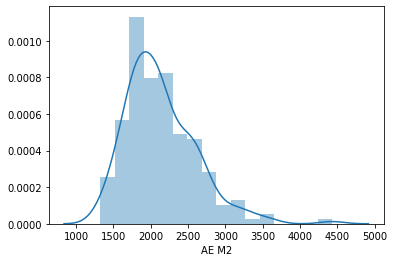

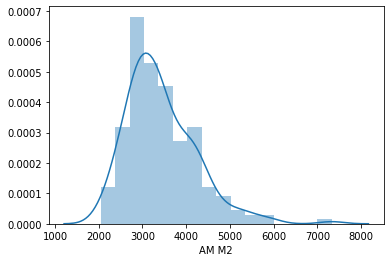

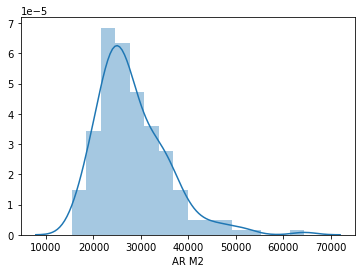

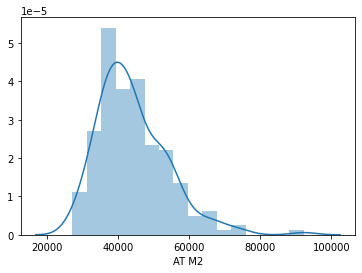

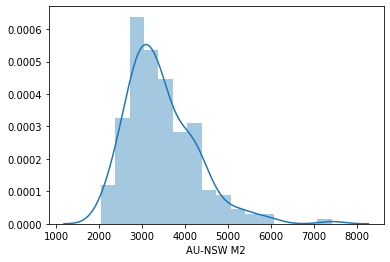

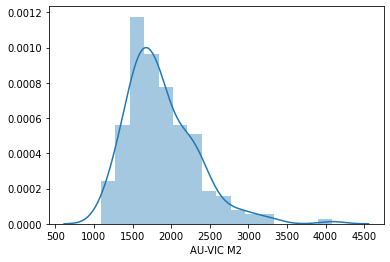

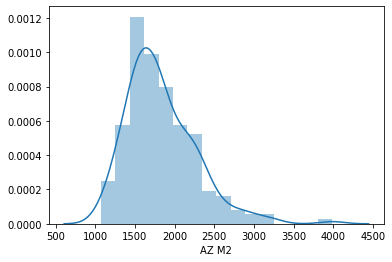

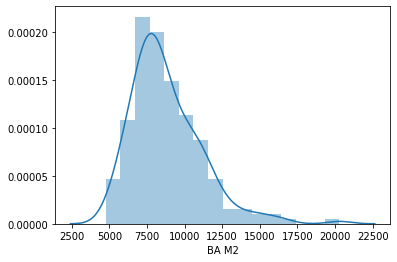

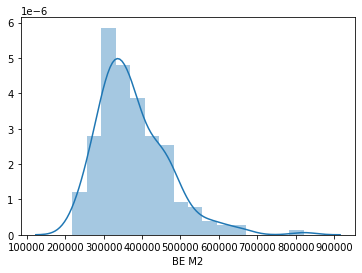

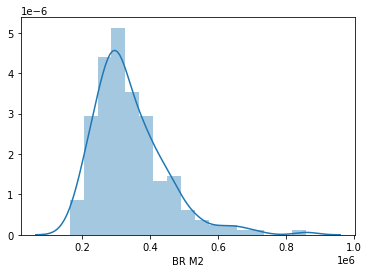

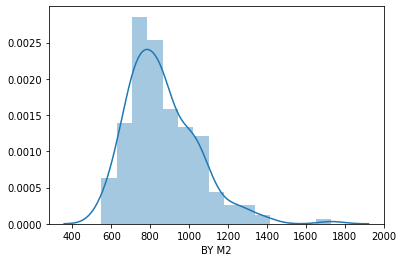

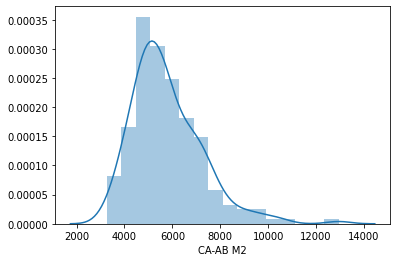

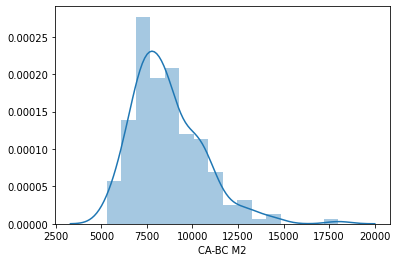

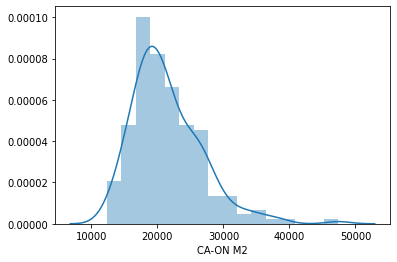

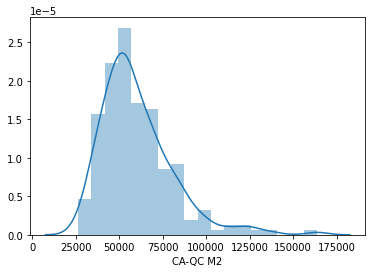

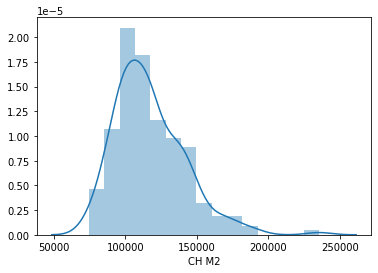

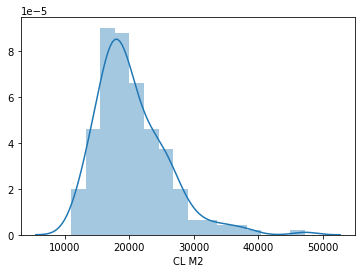

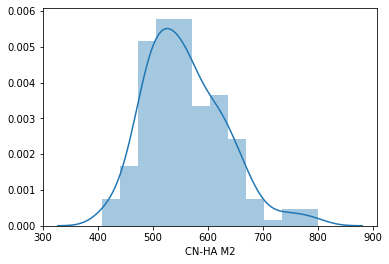

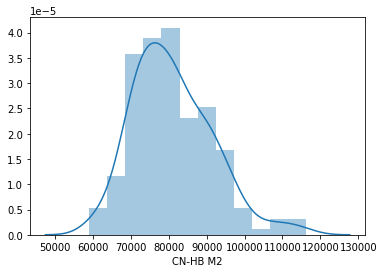

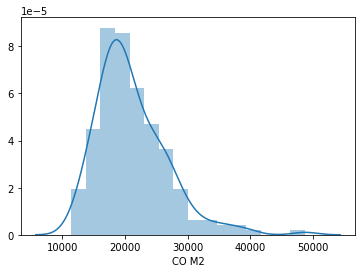

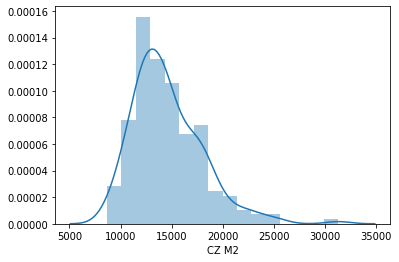

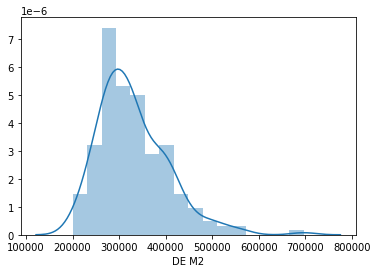

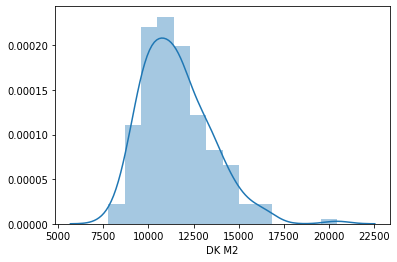

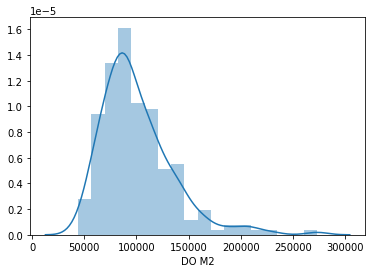

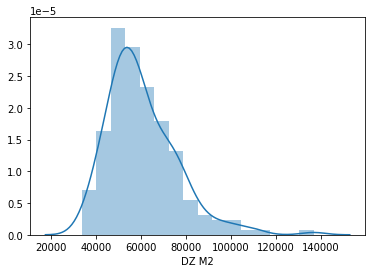

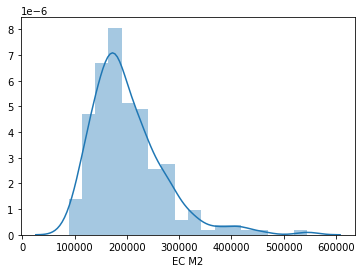

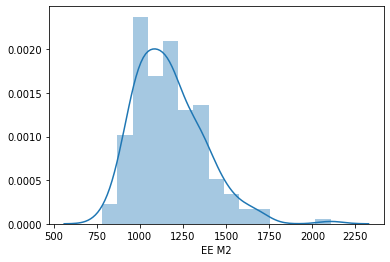

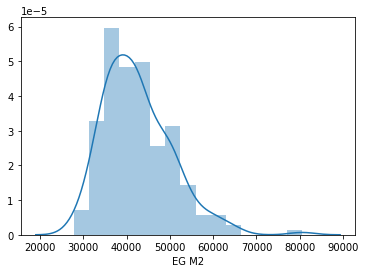

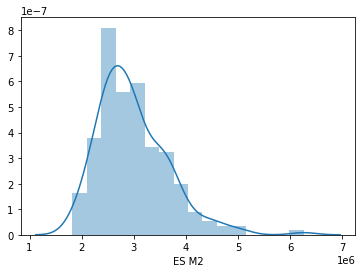

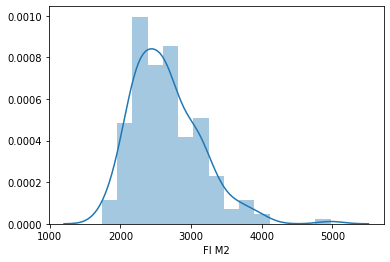

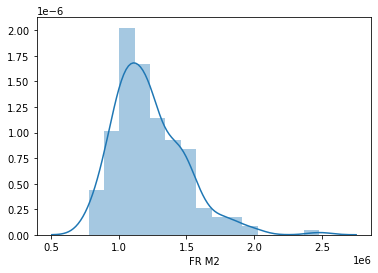

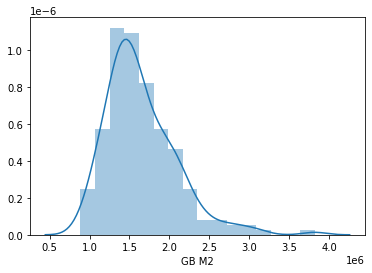

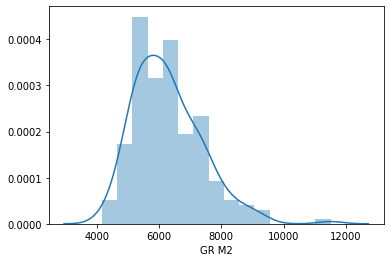

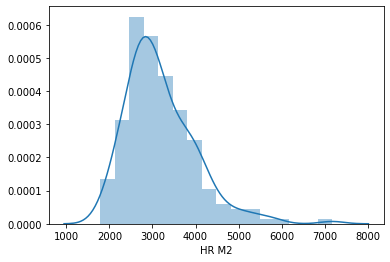

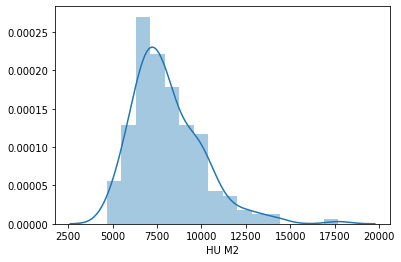

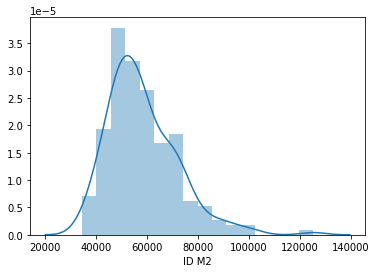

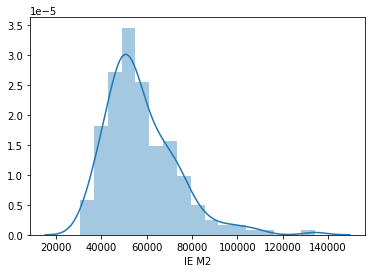

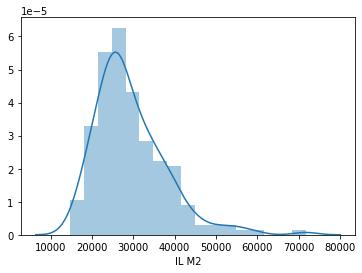

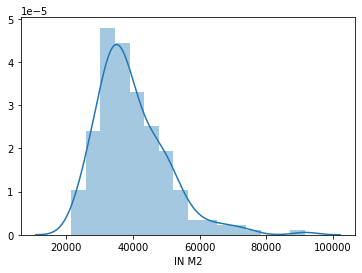

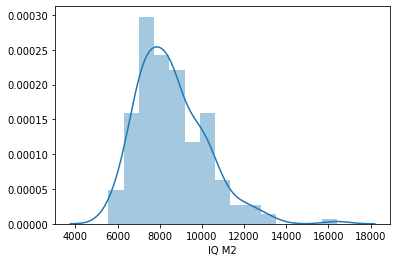

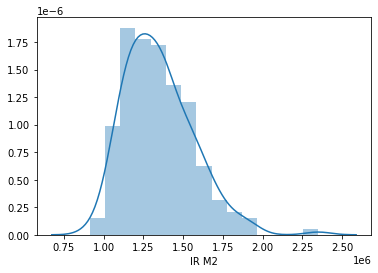

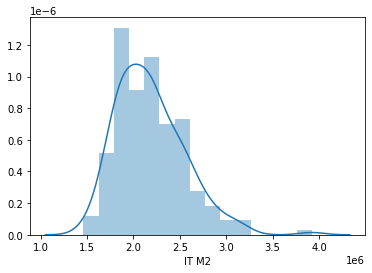

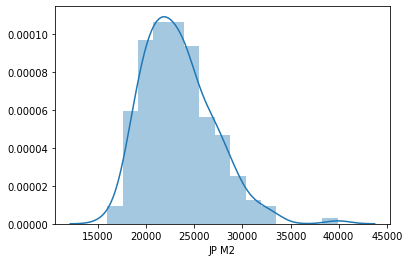

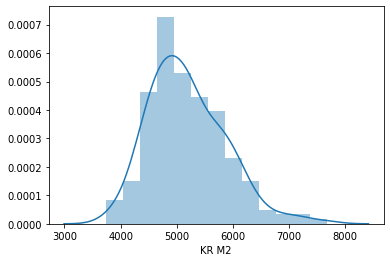

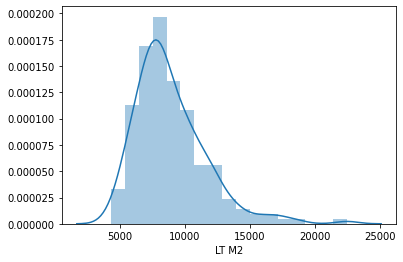

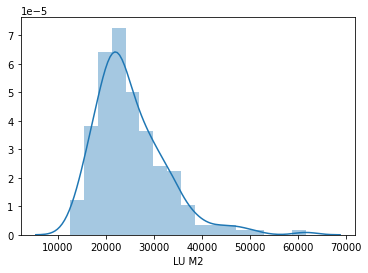

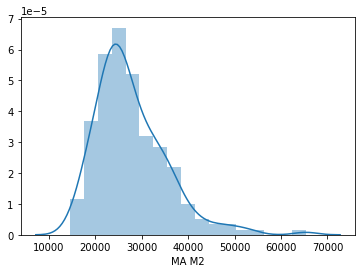

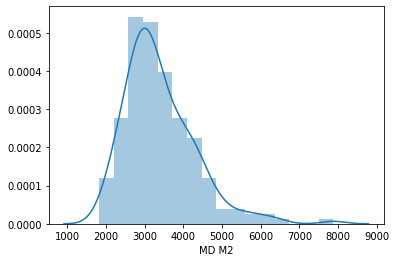

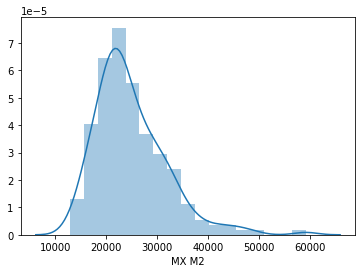

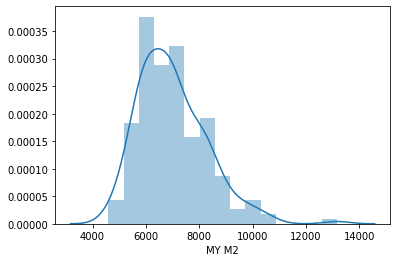

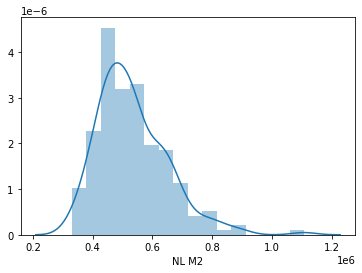

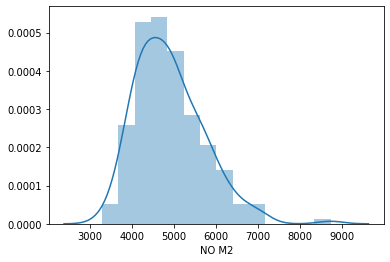

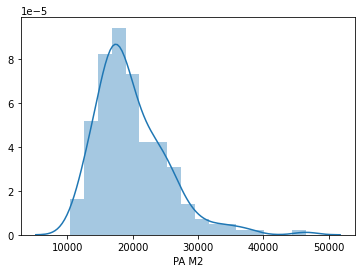

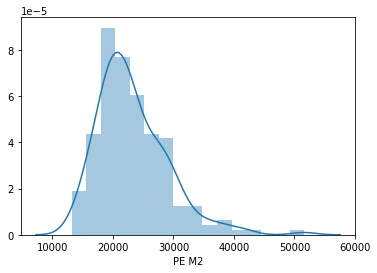

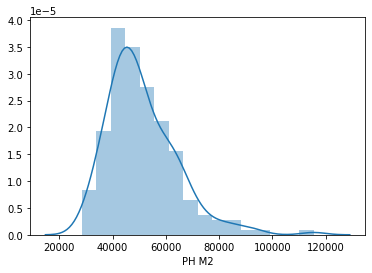

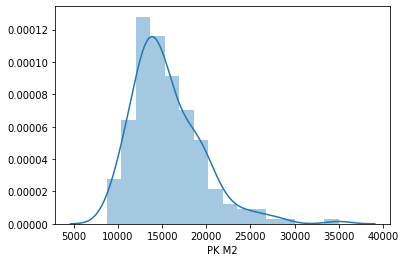

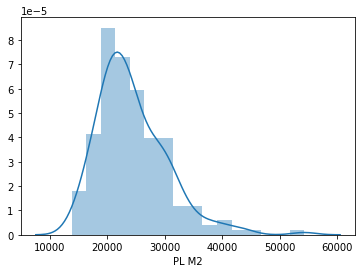

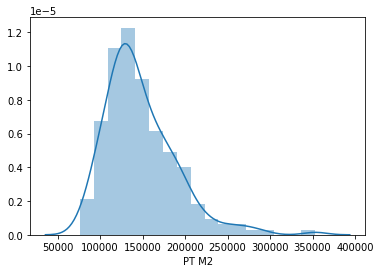

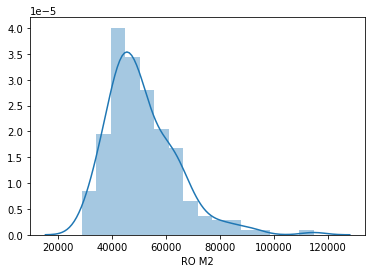

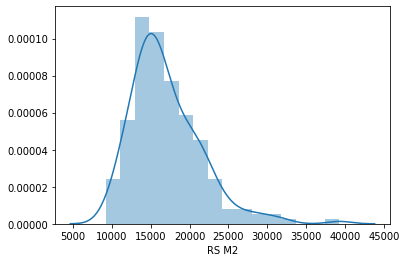

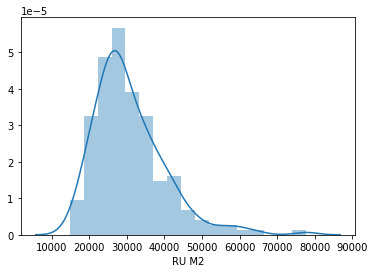

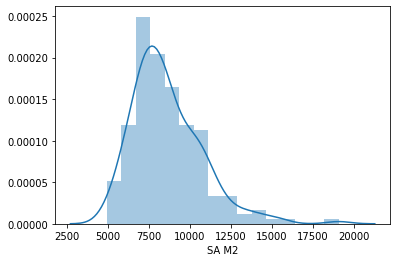

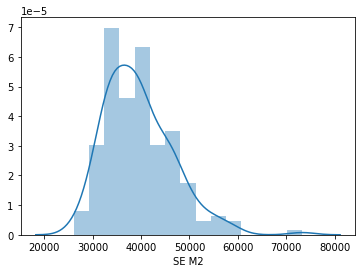

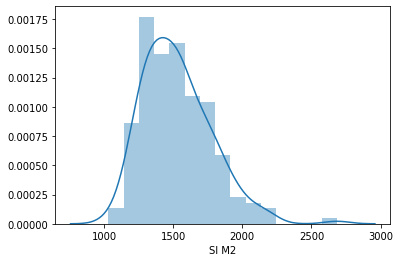

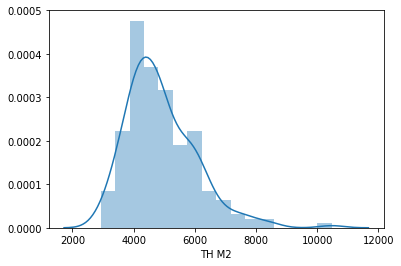

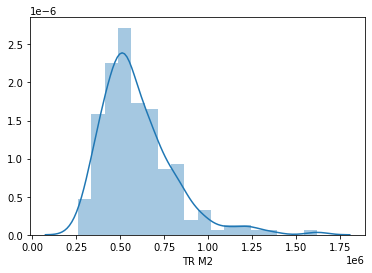

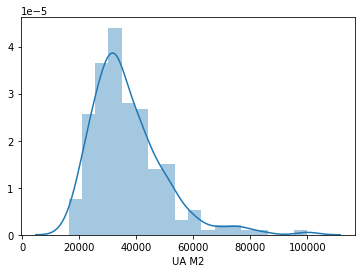

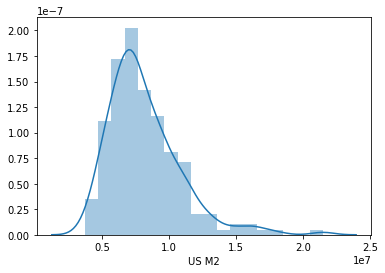

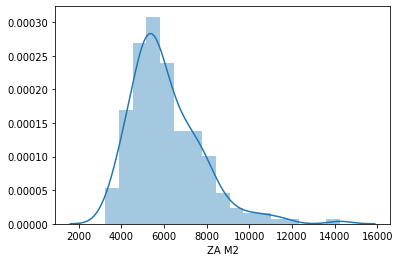

In [0]:
import seaborn
from matplotlib import pyplot as plt
for code in codes_to_predict:
  try:
    s = samples[f"{code} M2"]
    seaborn.distplot(s)
    plt.show()
  except KeyError:
    pass

## Add PlaguePlus data for comparison

[PlaguePlus.com](https://PlaguePlus.com) solves the same prediction problem and publishes its estimates in [this spreadsheet](https://docs.google.com/spreadsheets/d/1Rl3uhYkKfZiYiiRyJEl7R5Xay2HNT20R1X1j1nDCnd8/edit). Let's add the data to compare to our estimates.

### Load PlaguePlus data

In [0]:


def load_plagueplus_data():
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Rl3uhYkKfZiYiiRyJEl7R5Xay2HNT20R1X1j1nDCnd8/edit') # plagueplus.com
    sheet = wb.worksheet('Estimated CSV (country level)')
    values = sheet.get_all_values()
    df = (pd.DataFrame(values[1:], columns=values[0])
      .assign(Code=lambda df: df["Country/Region"].map(name_to_code))
      .assign(Estimated=lambda df: df['Estimated'].str.replace(',', ''))
      .replace(r'^\s*$', np.nan, regex=True)
      .astype({ "Estimated": float })
      .rename(columns = { "Estimated": "PredictedPlaguePlus" })
      .drop(columns=["Lat", "Long", "Population", "Estimated Per Capita"])
      .round({ "PredictedPlaguePlus": 0 }))
    return df

plagueplus = load_plagueplus_data()

## Display our predictions and PlaguePlus data

In [0]:
predictions_with_pp = prediction.filter(["PredictedCasesM1", "PredictedCasesM2", "PredictedCasesM3"]).merge(plagueplus, on="Code")

# Reorder columns
columns = predictions_with_pp.columns.tolist()
columns = [columns[0], columns[-2]] + columns[1:-2] + [columns[-1]]

predictions_with_pp[columns]

,Code,Country/Region,PredictedCasesM1,PredictedCasesM2,PredictedCasesM3,PredictedPlaguePlus
0,AE,United Arab Emirates,1672.0,2090.0,10240.0,77000.0
1,AM,Armenia,2678.0,3347.0,13260.0,5000.0
2,AR,Argentina,21851.0,27313.0,22660.0,13000.0
3,AT,Austria,34546.0,43182.0,55645.0,47000.0
4,AZ,Azerbaijan,1429.0,1786.0,4000.0,37000.0
...,...,...,...,...,...,...
59,TH,Thailand,6633.0,4783.0,18750.0,123000.0
60,TR,Turkey,455680.0,569600.0,181350.0,156000.0
61,UA,Ukraine,28160.0,35200.0,8970.0,12000.0
62,US,US,6237192.0,7796490.0,2437620.0,8874000.0
